In [32]:
!pip install wikipedia
     

from operator import itemgetter
import networkx as nx
import wikipedia
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.patches as mpatches
     

nx.__version__
!pip install scipy==1.8

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [33]:
class Pipeline:
    def __init__(self):
        self.tasks = []
        
    def task(self, depends_on=None):
        idx = 0
        if depends_on:
            idx = self.tasks.index(depends_on) + 1
        def inner(f):
            self.tasks.insert(idx, f)
            return f
        return inner
    
    def run(self, input_):
        output = input_
        for task in self.tasks:
            output = task(output)
        return output

In [34]:
pipeline = Pipeline()

@pipeline.task()
def get_nodes_of_wiki(seed, num_layers = 2, DEBUG = False):
  print('Capturing data')
  SEED = seed.title()
  STOPS = ("International Standard Serial Number",
         "International Standard Book Number",
         "National Diet Library",
         "International Standard Name Identifier",
         "International Standard Book Number (Identifier)",
         "Pubmed Identifier", 
         "Pubmed Central",
         "Digital Object Identifier", 
         "Arxiv",
         "Proc Natl Acad Sci Usa", 
         "Bibcode",
         "Library Of Congress Control Number", 
         "Jstor",
         "Doi (Identifier)",
         "Isbn (Identifier)",
         "Pmid (Identifier)",
         "Arxiv (Identifier)",
         "Bibcode (Identifier)")
  todo_lst = [(0, SEED)] 
  todo_set = set(SEED) 
  done_set = set()
  g = nx.DiGraph()
  layer, page = todo_lst[0]
  while layer < num_layers:
    del todo_lst[0]
    done_set.add(page)
  
    # Show progress
    if DEBUG:
      print(layer, page) 
  
    # Attempt to download the selected page.
    try:
      wiki = wikipedia.page(page)
    except:
      if DEBUG:
        print("Could not load", page)
      layer, page = todo_lst[0]
      continue
  
    for link in wiki.links:
      link = link.title()
      if link not in STOPS and not link.startswith("List Of"):
        if link not in todo_set and link not in done_set:
          todo_lst.append((layer + 1, link))
          todo_set.add(link)
        g.add_edge(page, link)
    layer, page = todo_lst[0]
  print('Data capture finished')   
  print("{} nodes, {} edges".format(len(g), nx.number_of_edges(g)))

  return g




In [35]:
@pipeline.task(depends_on=get_nodes_of_wiki)
def remove_duplicate_node(g):

  g.remove_edges_from(nx.selfloop_edges(g))

  duplicates = [(node, node + "s") 
                for node in g if node + "s" in g
              ]

  for dup in duplicates:
    g = nx.contracted_nodes(g, *dup, self_loops=False)

  print(duplicates)

  duplicates = [(x, y) for x, y in 
                [(node, node.replace("-", " ")) for node in g]
                  if x != y and y in g]
  print(duplicates)

  for dup in duplicates:
    g = nx.contracted_nodes(g, *dup, self_loops=False)

  nx.set_node_attributes(g, 0,"contraction")
  nx.set_edge_attributes(g, 0,"contraction")
  print('Duplicates removed')
  print("{} nodes, {} edges".format(len(g), nx.number_of_edges(g)))
  return g

In [36]:
@pipeline.task(depends_on=remove_duplicate_node)
def filter_nodes_with_degree_gt(g,degree = 2):
  core = [node for node, drg in dict(g.degree()).items() if drg > degree ]
  subgraf_g = nx.subgraph(g,core)
  print('Filter')
  print("{} nodes, {} edges".format(len(subgraf_g), nx.number_of_edges(subgraf_g)))
  return subgraf_g



In [37]:
def plot_degree_centrality(subgraf_g,pos):
  #the degree centrality of network(g)
  fig, ax = plt.subplots(1,1,figsize=(10,8))

  # layout position
  #pos = nx.spring_layout(subgraf_g,seed=8375,k=0.2)
  # color of nodes
  color = list(dict(nx.degree_centrality(subgraf_g)).values())
  # draw edges
  nx.draw_networkx_edges(subgraf_g,
                        pos=pos,
                        alpha=0.4, ax=ax)
  # draw nodes
  nodes = nx.draw_networkx_nodes(subgraf_g,
                  pos=pos,
                  node_color=color,
                  cmap=plt.cm.jet,
                  ax=ax)
  # draw labels
  nx.draw_networkx_labels(subgraf_g, pos=pos,
                          font_color='white',
                          font_size = 4, 
                          ax=ax)
  plt.axis("off")
  plt.colorbar(nodes)
  plt.savefig('degree_centrality.png', transparent=True,dpi=300)
  plt.show()

In [38]:
def plot_closeness_centrality(subgraf_g,pos):
  #the degree centrality of network(g)
  fig, ax = plt.subplots(1,1,figsize=(10,8))

  # layout position
  #pos = nx.spring_layout(subgraf_g,seed=8375,k=0.2)
  # color of nodes
  color = list(dict(nx.closeness_centrality(subgraf_g)).values())
  # draw edges
  nx.draw_networkx_edges(subgraf_g,
                        pos=pos,
                        alpha=0.4, ax=ax)
  # draw nodes
  nodes = nx.draw_networkx_nodes(subgraf_g,
                  pos=pos,
                  node_color=color,
                  cmap=plt.cm.jet,
                  ax=ax)
  # draw labels
  nx.draw_networkx_labels(subgraf_g, pos=pos,
                          font_color='white',
                          font_size = 4, 
                          ax=ax)
  plt.axis("off")
  plt.colorbar(nodes)
  plt.savefig('closeness_centrality.png', transparent=True,dpi=300)
  plt.show()

In [39]:
def plot_betweenness_centrality(subgraf_g,pos):
  #the degree centrality of network(g)
  fig, ax = plt.subplots(1,1,figsize=(10,8))

  # layout position
  #pos = nx.spring_layout(subgraf_g,seed=8375,k=0.2)
  # color of nodes
  color = list(dict(nx.betweenness_centrality(subgraf_g)).values())
  # draw edges
  nx.draw_networkx_edges(subgraf_g,
                        pos=pos,
                        alpha=0.4, ax=ax)
  # draw nodes
  nodes = nx.draw_networkx_nodes(subgraf_g,
                  pos=pos,
                  node_color=color,
                  cmap=plt.cm.jet,
                  ax=ax)
  # draw labels
  nx.draw_networkx_labels(subgraf_g, pos=pos,
                          font_color='white',
                          font_size = 4, 
                          ax=ax)
  plt.axis("off")
  plt.colorbar(nodes)
  plt.savefig('dbetweenness_centrality.png', transparent=True,dpi=300)
  plt.show()

In [40]:
def plot_eigenvector_centrality(subgraf_g,pos):
  #the degree centrality of network(g)
  fig, ax = plt.subplots(1,1,figsize=(10,8))

  # layout position
  #pos = nx.spring_layout(subgraf_g,seed=8375,k=0.2)
  # color of nodes
  color = list(dict(nx.eigenvector_centrality(subgraf_g)).values())
  # draw edges
  nx.draw_networkx_edges(subgraf_g,
                        pos=pos,
                        alpha=0.4, ax=ax)
  # draw nodes
  nodes = nx.draw_networkx_nodes(subgraf_g,
                  pos=pos,
                  node_color=color,
                  cmap=plt.cm.jet,
                  ax=ax)
  # draw labels
  nx.draw_networkx_labels(subgraf_g, pos=pos,
                          font_color='white',
                          font_size = 4, 
                          ax=ax)
  plt.axis("off")
  plt.colorbar(nodes)
  plt.savefig('eigenvector_centrality.png', transparent=True,dpi=300)
  plt.show()
  

In [ ]:
def plot_pdf(subgraf_g):  
  plt.style.use("fivethirtyeight")
  #plt.style.use("default")
  degree_sequence = sorted([d for n, d in subgraf_g.degree()], reverse=True) 
  fig, ax = plt.subplots(1,1,figsize=(10,8))

  sns.histplot(degree_sequence,bins=7,label="Count",ax=ax)
  ax2 = ax.twinx()
  sns.kdeplot(degree_sequence,color='r',label="Probability Density Function (PDF)",ax=ax2)

  # ask matplotlib for the plotted objects and their labels
  lines, labels = ax.get_legend_handles_labels()
  lines2, labels2 = ax2.get_legend_handles_labels()
  ax2.legend(lines + lines2, labels + labels2, loc=0)

  ax.grid(False)
  ax2.grid(False)
  ax.set_xlabel("Degree")
  ax2.set_ylabel("Probability")

  plt.savefig('probability_density_function.png', transparent=True,dpi=600,bbox_inches="tight")
  plt.show()

In [41]:
@pipeline.task(depends_on=filter_nodes_with_degree_gt)
def show_results(subgraf_g):
  
  plot_pdf(subgraf_g)
  pos = nx.spring_layout(subgraf_g,seed=8375,k=0.2)
  
  plot_degree_centrality(subgraf_g,pos)
  plot_closeness_centrality(subgraf_g,pos)
  plot_betweenness_centrality(subgraf_g,pos)
  plot_eigenvector_centrality(subgraf_g,pos)


  bc = pd.Series(nx.betweenness_centrality(subgraf_g))
  dc = pd.Series(nx.degree_centrality(subgraf_g))
  ec = pd.Series(nx.eigenvector_centrality(subgraf_g))
  cc = pd.Series(nx.closeness_centrality(subgraf_g))

  df = pd.DataFrame.from_dict({"Betweenness": bc,
                              "Degree": dc,
                              "EigenVector": ec,
                              "Closeness": cc})
  print('Plot all')
  df.reset_index(inplace=True,drop=True)
  fig = sns.PairGrid(df)
  fig.map_upper(sns.scatterplot)
  fig.map_lower(sns.kdeplot, cmap="Reds_r")
  fig.map_diag(sns.kdeplot, lw=2, legend=False)


  plt.savefig('all.png', transparent=True,dpi=800,bbox_inches="tight")
  plt.show()
  print('Plot Core and shell')
  # the degree of network(g2)
  fig, ax = plt.subplots(1,1,figsize=(10,8))

  # Find k-cores
  g2_core_9 = nx.k_shell(subgraf_g, 9)
  g2_core_10 = nx.k_core(subgraf_g, 10)

  # layout position
  pos = nx.spring_layout(subgraf_g,seed=123456789,k=0.3)

  # draw edges
  nx.draw_networkx_edges(subgraf_g,
                        pos=pos,
                        alpha=0.4, ax=ax)

  # draw nodes
  nodes = nx.draw_networkx_nodes(subgraf_g,
                  pos=pos,
                  node_color="#333333")

  # draw nodes
  nodes = nx.draw_networkx_nodes(g2_core_9,
                  pos=pos,
                  node_color="blue")

  nodes = nx.draw_networkx_nodes(g2_core_10,
                  pos=pos,
                  node_color="red")

  # static legend
  red_patch = mpatches.Patch(color='red', label='10-core')
  blue_patch = mpatches.Patch(color='blue', label='9-shell')
  plt.legend(handles=[red_patch,blue_patch])

  plt.axis("off")
  plt.savefig('k-core_sociopatterns.png', transparent=True,dpi=600)
  plt.show()

Capturing data


/usr/local/lib/python3.8/dist-packages/wikipedia/wikipedia.py:389: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /usr/local/lib/python3.8/dist-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Data capture finished
12715 nodes, 17754 edges
[('Neural Network', 'Neural Networks'), ('Deepfake', 'Deepfakes'), ('Non-Fungible Token', 'Non-Fungible Tokens'), ('Complex System', 'Complex Systems'), ('Database', 'Databases'), ('Pixel Shader', 'Pixel Shaders'), ('Vertex Shader', 'Vertex Shaders'), ('Arthropod', 'Arthropods'), ('Chordate', 'Chordates'), ('Deuterostome', 'Deuterostomes'), ('Echinoderm', 'Echinoderms'), ('Mollusc', 'Molluscs'), ('Nematode', 'Nematodes'), ('Protostome', 'Protostomes'), ('Sponge', 'Sponges'), ('Vertebrate', 'Vertebrates'), ('Working Animal', 'Working Animals'), ('Hate Group', 'Hate Groups'), ('Convolutional Neural Network', 'Convolutional Neural Networks'), ('Image', 'Images'), ('Artificial Neural Network', 'Artificial Neural Networks'), ('Convolution', 'Convolutions'), ('Generative Adversarial Network', 'Generative Adversarial Networks'), ('Recurrent Neural Network', 'Recurrent Neural Networks'), ('Youtuber', 'Youtubers'), ('Academy Award', 'Academy Awards

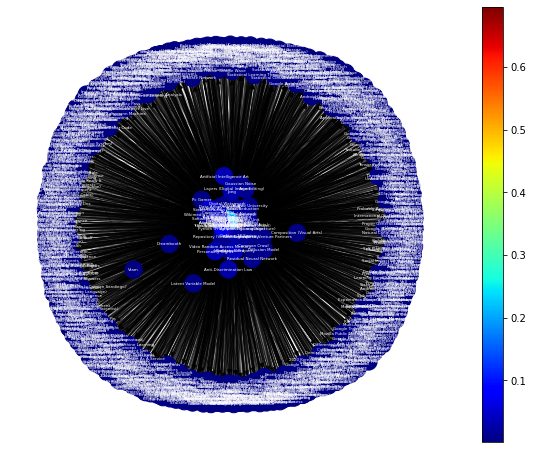

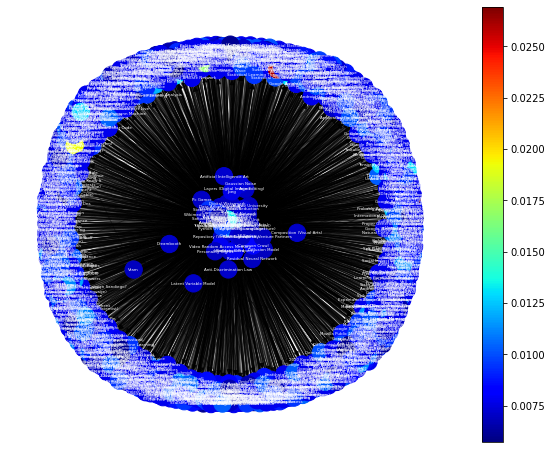

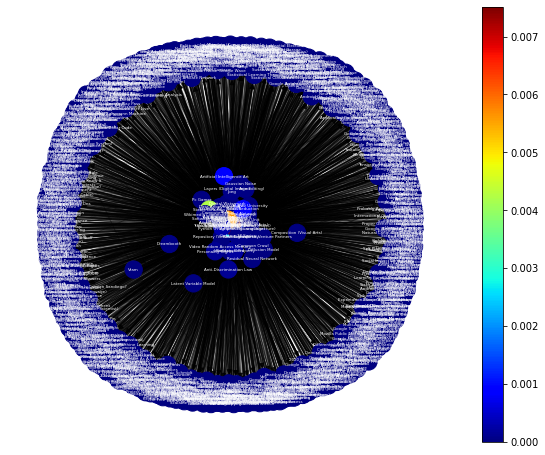

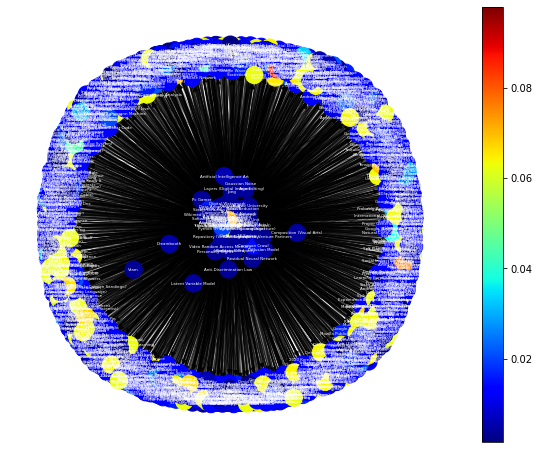

Plot all


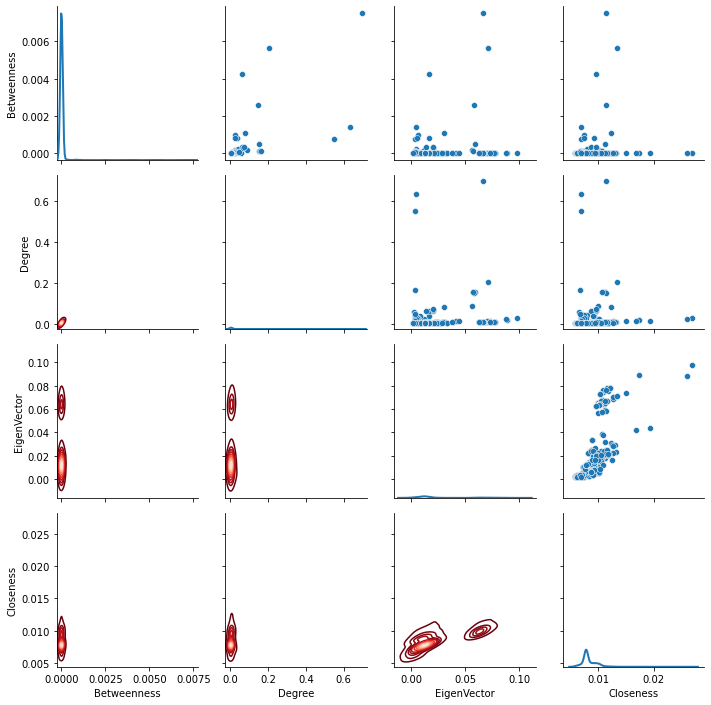

Plot Core and shell


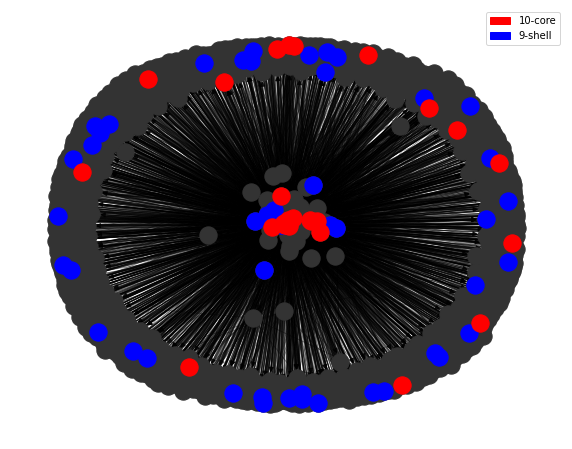

In [42]:
pipeline.run('Stable Diffusion')